In [20]:
!pip install mlxtend

In [21]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, average_precision_score
from sklearn.preprocessing import LabelEncoder
from scipy.signal import hilbert
from multiprocessing import Pool, cpu_count
from tqdm import tqdm
import pickle
import os


from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, RepeatVector, TimeDistributed, Dropout
from tensorflow.keras.callbacks import EarlyStopping

%matplotlib inline

In [23]:
def data_preprocessing_lstm(data):
    print("")
    print(".")
    print(data.info())
    print(data.describe())
    print("。")

    # categorical_features = ['protocol_type', 'service', 'flag', 'land', 'logged_in', 'is_host_login', 'is_guest_login']
    data_encoded = data # pd.get_dummies(data, columns=categorical_features)


    numerical_features = data_encoded.select_dtypes(include=['float64', 'int64']).columns
    scaler = StandardScaler()
    data_encoded[numerical_features] = scaler.fit_transform(data_encoded[numerical_features])


    data_encoded = data_encoded.replace([np.inf, -np.inf], np.nan)
    data_encoded = data_encoded.dropna()

    data_encoded.label=data_encoded.label.apply(lambda x: 0 if x == 'Normal' else 1)

    #train_samples =data_encoded.sample(100000)
    train_samples =data_encoded


    X = train_samples.drop(['time', 'label'], axis=1)

    y_test = train_samples['label']


    X = X.astype(np.float64)

    X = np.nan_to_num(X, nan=0.0, posinf=0.0, neginf=0.0)

    # scaler = MinMaxScaler()
    # X = scaler.fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X, y_test, test_size=0.2, random_state=42)

    print("")
    return X_train, X_test, y_train, y_test, train_samples

In [24]:
df = pd.read_csv("data/Power_System_IDS/Train.csv")

In [25]:
df.label.value_counts()

label
Normal        910
Masquerade    794
Injection     202
Replay        200
Fault          82
Name: count, dtype: int64

In [26]:
def data_preprocessing(data):
    # Drop any existing NaN values in the dataset
    data.dropna(inplace=True)
    
    categorical_features = ['protocol_type', 'service', 'flag', 'land', 'logged_in', 'is_host_login', 'is_guest_login']
    data_encoded = pd.get_dummies(data, columns=categorical_features)

    numerical_features = data_encoded.select_dtypes(include=['float16', 'int8']).columns
    print("Numerical Features:", numerical_features)
    scaler = StandardScaler()
    data_encoded[numerical_features] = scaler.fit_transform(data_encoded[numerical_features])

    X = data_encoded.drop('label', axis=1)
    y = data_encoded['label']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    return X_train, X_test, y_train, y_test, data


def train_decision_tree(X_train, y_train):
    param_grid = {'max_depth': [20], 'min_samples_split': [2]}
    clf = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=5, scoring='f1_weighted', n_jobs=-1)

    label_encoder = LabelEncoder()
    y_train_encoded = label_encoder.fit_transform(y_train)
    
    clf.fit(X_train, y_train_encoded)
    return clf, label_encoder

def evaluate_performance(y_true, y_pred):
    
    prob=[-0.2,-0.1,-0.05,0,0.005,0.1, 0.2,0.3,0.4]
    for p in prob:
        pred_value =[1 if i<p   else 0 for i in y_pred]
        f1=f1_score(y_true,pred_value)
        acc=accuracy_score(y_true,pred_value)
        precision=average_precision_score(y_true,pred_value)
        recall= recall_score(y_true,pred_value)
        print(f'prob ={p} and f1 score ={f1} : accuracy={acc} : precision={precision} : recall={recall}')
        print(pred_value.count(0),pred_value.count(1))
    return acc, precision, recall, f1, pred_value

def anomaly_detection(X_train_features, y_train, X_test_features, y_test):
    clf, label_encoder = train_decision_tree(X_train_features, y_train)
    y_pred_encoded = clf.predict(X_test_features)
    y_pred = label_encoder.inverse_transform(y_pred_encoded)
    return y_pred

def print_anomalies(data, y_test, y_pred):
    test_indices = data.index[data.index.isin(y_test.index)]
    anomaly_data = data.loc[test_indices[y_pred != 'normal.']]


In [27]:

data = pd.read_csv("data/Power_System_IDS/Train.csv")

X_train, X_test, y_train, y_test, original_data = data_preprocessing_lstm(data)

df_train= original_data[original_data.label==0]

X_train_new = df_train.drop(['time', 'label'], axis=1)

X_train_new = X_train_new.astype(np.float64)

X_train_new = np.nan_to_num(X_train_new, nan=0.0, posinf=0.0, neginf=0.0)




.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2188 entries, 0 to 2187
Data columns (total 54 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   time                  2188 non-null   int64  
 1   sqNum                 2188 non-null   int64  
 2   stnum                 2188 non-null   int64  
 3   state_cb              2188 non-null   int64  
 4   sqDiff                2188 non-null   int64  
 5   stDiff                2188 non-null   int64  
 6   timeLastMsg           2188 non-null   int64  
 7   recentChange          2188 non-null   int64  
 8   MU1Cs                 2188 non-null   int64  
 9   MU2Cs                 2188 non-null   int64  
 10  MU3Cs                 2188 non-null   int64  
 11  MU4Cs                 2188 non-null   int64  
 12  Cs                    2188 non-null   int64  
 13  consistency           2188 non-null   int64  
 14  threePhaseVSum        2188 non-null   float64
 15  threePhaseCSum    

In [28]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape, original_data.shape, df_train.shape

((1750, 52), (438, 52), (1750,), (438,), (2188, 54), (910, 54))

In [30]:
input_shape = (X_train_new.shape[1], 1)

model = Sequential()
model.add(LSTM(128, activation='relu', input_shape=input_shape, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64, activation='relu', return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(RepeatVector(1))
model.add(LSTM(32, activation='relu', return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64, activation='relu', return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(128, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(1)))

model.compile(optimizer='adam', loss='mean_squared_error')

C:\Users\zakar\anaconda3\envs\DeepLearning6150\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [31]:
# Train the model
# history = model.fit(X_train_new, X_train_new, epochs=20, batch_size=16, validation_split=0.1, callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)])
history = model.fit(X_train_new, X_train_new, epochs=150, batch_size=32, validation_split=0.1)

# Plot training history if needed

X_test_slice = X_test[0:200, :]
y_test_slice = y_test[0:200]

# Make predictions on the test set
y_pred = model.predict(X_test_slice)
# arr = np.squeeze(predictions)


accuracy, precision, recall, f1, pred_value = evaluate_performance (y_test_slice, y_pred)

Epoch 1/150
26/26 ━━━━━━━━━━━━━━━━━━━━ 10s 68ms/step - loss: 0.6977 - val_loss: 0.6038
Epoch 2/150
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.7769 - val_loss: 0.5993
Epoch 3/150
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.7918 - val_loss: 0.5954
Epoch 4/150
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.6671 - val_loss: 0.5939
Epoch 5/150
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.7207 - val_loss: 0.5926
Epoch 6/150
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.6578 - val_loss: 0.5922
Epoch 7/150
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.6612 - val_loss: 0.5918
Epoch 8/150
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.7501 - val_loss: 0.5930
Epoch 9/150
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.7445 - val_loss: 0.5917
Epoch 10/150
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.6863 - val_loss: 0.5914
Epoch 11/150
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.6586 - val_loss: 0.5911
Epoch 12/150
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/ste

In [32]:
y_test[0:200]

571     0
1317    1
2116    1
1563    1
1146    1
       ..
1821    0
120     1
1368    0
564     0
1418    0
Name: label, Length: 200, dtype: int64

In [33]:

arr = np.squeeze(y_pred)

# Calculate reconstruction errors
mse = []

# Calculate reconstruction errors
for i in range(0, y_test_slice.shape[0]):
    mse.append(np.mean(np.power(y_test_slice.iloc[i] - arr[i], 2)))

# Convert mse to numpy array if needed
mse = np.array(mse)
threshold = np.mean(mse) + 2 * np.std(mse)

# Classify anomalies
anomalies = np.where(mse > 0.1, 1, 0)

# # Evaluate the model
accuracy_2 = np.mean(anomalies == y_test_slice)
print("Accuracy:", accuracy_2)



Accuracy: 0.995


(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='predicted label', ylabel='true label'>)

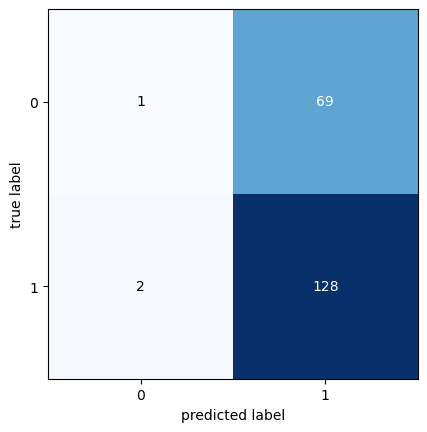

In [34]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(y_test_slice,pred_value )
plot_confusion_matrix(conf_mat=mat)